# scores in function of token overlap


In [1]:
import os
import json
import math
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

scores = {"ner": {}, "pos": {}, "copa": {}, "qa": {}}
f1 = {"ner": "eval_f1", "copa": "eval_acc", "pos": "eval_f1_macro", "qa": "f1"}
inf = math.inf
# From huggingface api, with our trained adapters (eu, sr)
existing_adapters = [
    "th",
    "my",
    "hi",
    "ilo",
    "ht",
    "tr",
    "mi",
    "vi",
    "is",
    "it",
    "ta",
    "jv",
    "ja",
    "sw",
    "qu",
    "de",
    "el",
    "et",
    "ru",
    "gn",
    "id",
    "en",
    "ar",
    "es",
    "tk",
    "zh",
    "mhr",
    "cdo",
    "xmf",
    "eu",
    "sr",
]
# scraped from cc-100 website
xlm_included_langs = [
    "af",
    "am",
    "ar",
    "as",
    "az",
    "be",
    "bg",
    "bn",
    "br",
    "bs",
    "ca",
    "cs",
    "cy",
    "da",
    "de",
    "el",
    "en",
    "eo",
    "es",
    "et",
    "eu",
    "fa",
    "ff",
    "fi",
    "fr",
    "fy",
    "ga",
    "gd",
    "gl",
    "gn",
    "gu",
    "ha",
    "he",
    "hi",
    "hr",
    "ht",
    "hu",
    "hy",
    "id",
    "ig",
    "is",
    "it",
    "ja",
    "jv",
    "ka",
    "kk",
    "km",
    "kn",
    "ko",
    "ku",
    "ky",
    "la",
    "lg",
    "li",
    "ln",
    "lo",
    "lt",
    "lv",
    "mg",
    "mk",
    "ml",
    "mn",
    "mr",
    "ms",
    "my",
    "ne",
    "nl",
    "no",
    "ns",
    "om",
    "or",
    "pa",
    "pl",
    "ps",
    "pt",
    "qu",
    "rm",
    "ro",
    "ru",
    "sa",
    "si",
    "sc",
    "sd",
    "sk",
    "sl",
    "so",
    "sq",
    "sr",
    "ss",
    "su",
    "sv",
    "sw",
    "ta",
    "te",
    "th",
    "tl",
    "tn",
    "tr",
    "ug",
    "uk",
    "ur",
    "uz",
    "vi",
    "wo",
    "xh",
    "yi",
    "yo",
    "zu",
    "zh",
]

for file in os.listdir("../eval_scores/selected"):
    if file.endswith(".json"):
        try:
            with open(os.path.join("../eval_scores/selected", file), "r") as f:
                data = json.load(f)
                task_name = file.split(".")[0]

                scores[task_name] = data

        except json.JSONDecodeError:
            print(f"Error decoding JSON for file: {file}")
        except KeyError:
            print("KeyError:", file)
scores_subset = {}
for task_name in scores:
    scores_subset[task_name] = {}
    for lang_name in scores[task_name]:
        if lang_name in existing_adapters:
            scores_subset[task_name][lang_name] = scores[task_name][lang_name]
token_overlap = {}
for file in os.listdir("../data/token_overlap"):
    if file.endswith(".json"):
        try:
            with open(os.path.join("../data/token_overlap", file), "r") as f:
                data = json.load(f)
                task_name = file.split("_")[0]
                token_overlap[task_name] = data
        except json.JSONDecodeError:
            print(f"Error decoding JSON for file: {file}")
        except KeyError:
            print("KeyError:", file)

In [2]:
def get_significance(task_name, option1, option2, alternative="two-sided", subset=scores):
    all_scores1 = []
    all_scores2 = []
    if task_name == "all":
        task_names = subset.keys()
    elif type(task_name) is str:
        task_names = [task_name]
    else:
        task_names = task_name
    for task_name in task_names:
        for lang_name in subset[task_name]:
            if option1 in subset[task_name][lang_name] and option2 in subset[task_name][lang_name]:
                score1 = subset[task_name][lang_name][option1]
                score2 = subset[task_name][lang_name][option2]
                if task_name == "qa":
                    # we divide the scores of qa by 100
                    score1 = score1 / 100
                    score2 = score2 / 100
                all_scores1.append(score1)
                all_scores2.append(score2)
    print("average scores")
    print(f"{option1}: {np.mean(all_scores1)}")
    print(f"{option2}: {np.mean(all_scores2)}")
    t_stat, p_val = stats.ttest_rel(all_scores1, all_scores2, alternative=alternative)
    print(f"t-statistic: {t_stat}")
    print(f"p-value: {p_val}")
    return t_stat, p_val

In [3]:
# we retrieve means of all scores, across languages
means = {}
for task_name in scores:
    means[task_name] = {}
    for lang_name in scores[task_name]:
        for key in scores[task_name][lang_name]:
            if key not in means[task_name]:
                means[task_name][key] = []
            means[task_name][key].append(scores[task_name][lang_name][key])
    for key in means[task_name]:
        means[task_name][key] = np.mean(means[task_name][key])

In [4]:
# we print the top 3 highest mean score for each task, and the english adapter baseline
for task_name in means:
    print(f"Task: {task_name}")
    sorted_means = sorted(means[task_name].items(), key=lambda x: x[1], reverse=True)
    for i in range(3):
        print(f"{sorted_means[i][0]}: {sorted_means[i][1]}")
    print("finetune baseline:", means[task_name]["finetune"])
    print("reconstructed base method:", means[task_name]["reconstructed_featural"])
    print()

Task: ner
reconstructed_featural_limit: 0.5125092701316386
reconstructed_syntactic_limit: 0.5107850690948645
reconstructed_morphological_limit: 0.5083653805724313
finetune baseline: 0.3900757022390063
reconstructed base method: 0.5013399275268126

Task: pos
no_train_gain: 0.4685519779311475
reconstructed_featural: 0.4679441087506307
baseline_task_adapter: 0.4672603118980092
finetune baseline: 0.38898662417653296
reconstructed base method: 0.4679441087506307

Task: copa
baseline_closest_featural: 0.5645454545454546
reconstructed_featural_limit: 0.5590909090909091
reconstructed_morphological_limit: 0.5572727272727273
finetune baseline: 0.5552727272727273
reconstructed base method: 0.5498181818181818

Task: qa
reconstructed_morphological_threshold: 0.7285715530023293
reconstructed_morphological_limit: 0.7284004003755643
reconstructed_featural_limit: 0.7281344543568334
finetune baseline: 0.5336718068640248
reconstructed base method: 0.7271252762822759


In [8]:
# we plot the scores in function of token overlap
# we create a dataframe with the "reconstructed" scores, the finetune scores and the token overlap

data_overlap = []
for task_name in scores:
    for lang_name in scores[task_name]:
        if lang_name in token_overlap[task_name]:
            for key in scores[task_name][lang_name]:
                data_overlap.append(
                    {
                        "task": task_name,
                        "lang": lang_name,
                        "score": scores[task_name][lang_name][key]
                        if task_name != "qa"
                        else scores[task_name][lang_name][key] / 100,
                        "token_coverage": token_overlap[task_name][lang_name]["token_coverage"],
                        "type_overlap": token_overlap[task_name][lang_name]["type_overlap"],
                        "option": key,
                    }
                )
df = pd.DataFrame(data_overlap)
# we will look at the subset that contains
# baseline_en, no_train_gain, reconstructed_featural
df_subset = df[df["option"].isin(["baseline_closest_featural", "finetune", "reconstructed_featural"])]
df_subset

,task,lang,score,token_coverage,type_overlap,option
0,ner,ace,0.209115,0.828497,0.702703,finetune
5,ner,ace,0.364238,0.828497,0.702703,reconstructed_featural
9,ner,ace,0.395833,0.828497,0.702703,baseline_closest_featural
18,ner,af,0.634340,0.797986,0.643863,finetune
21,ner,af,0.726658,0.797986,0.643863,reconstructed_featural
...,...,...,...,...,...,...
4055,qa,vi,0.007371,0.319490,0.607860,reconstructed_featural
4059,qa,vi,0.007320,0.319490,0.607860,baseline_closest_featural
4068,qa,zh,0.005210,0.362762,0.222652,finetune
4073,qa,zh,0.006550,0.362762,0.222652,reconstructed_featural


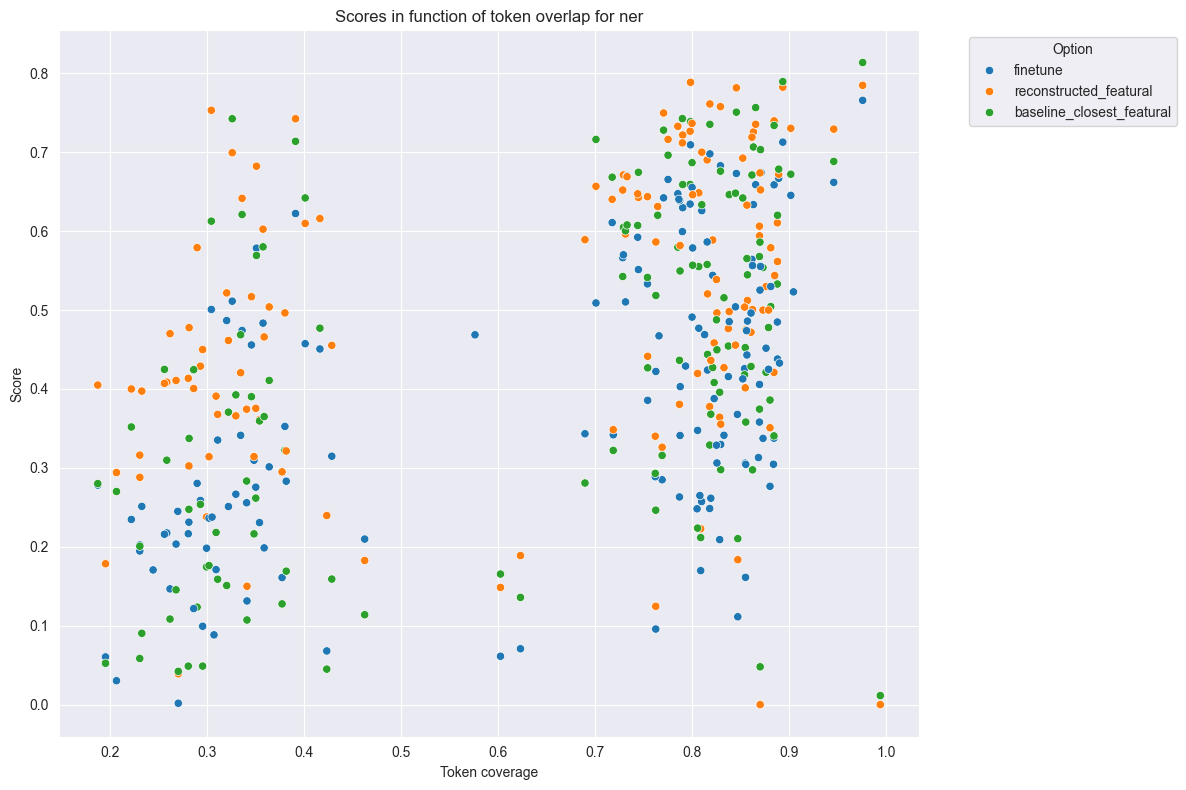

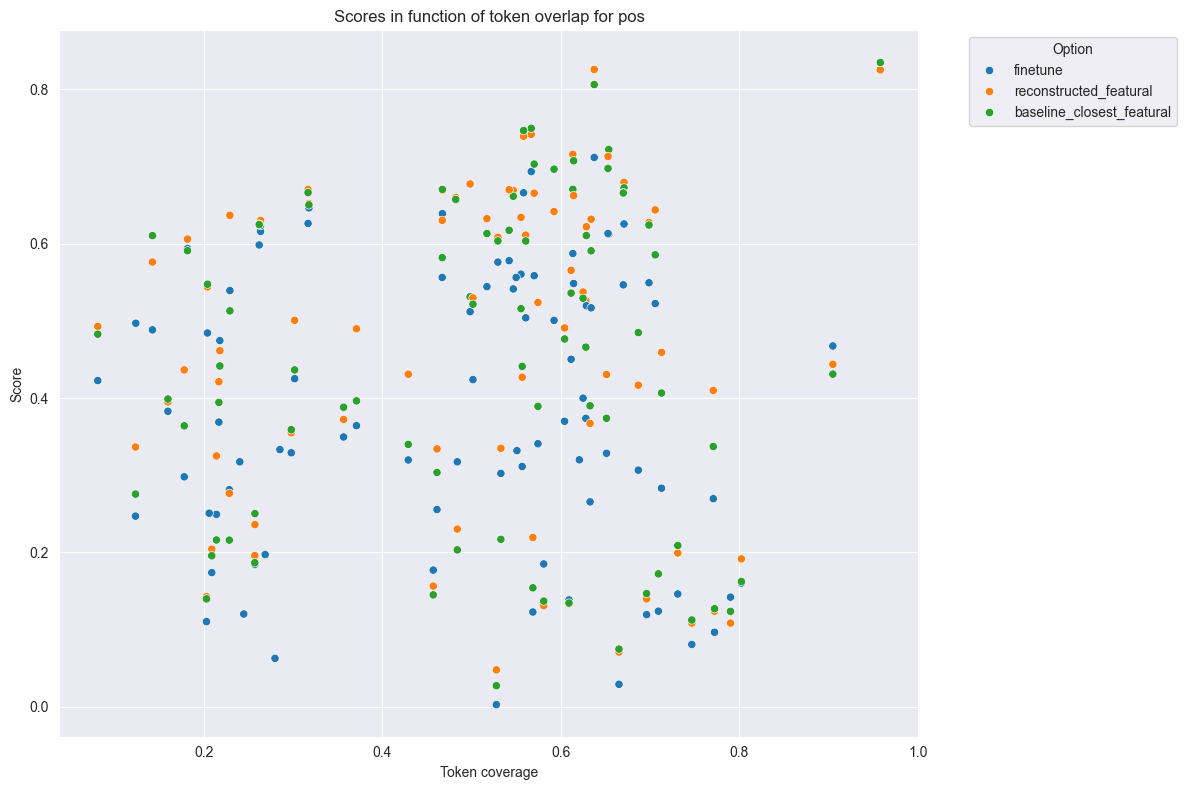

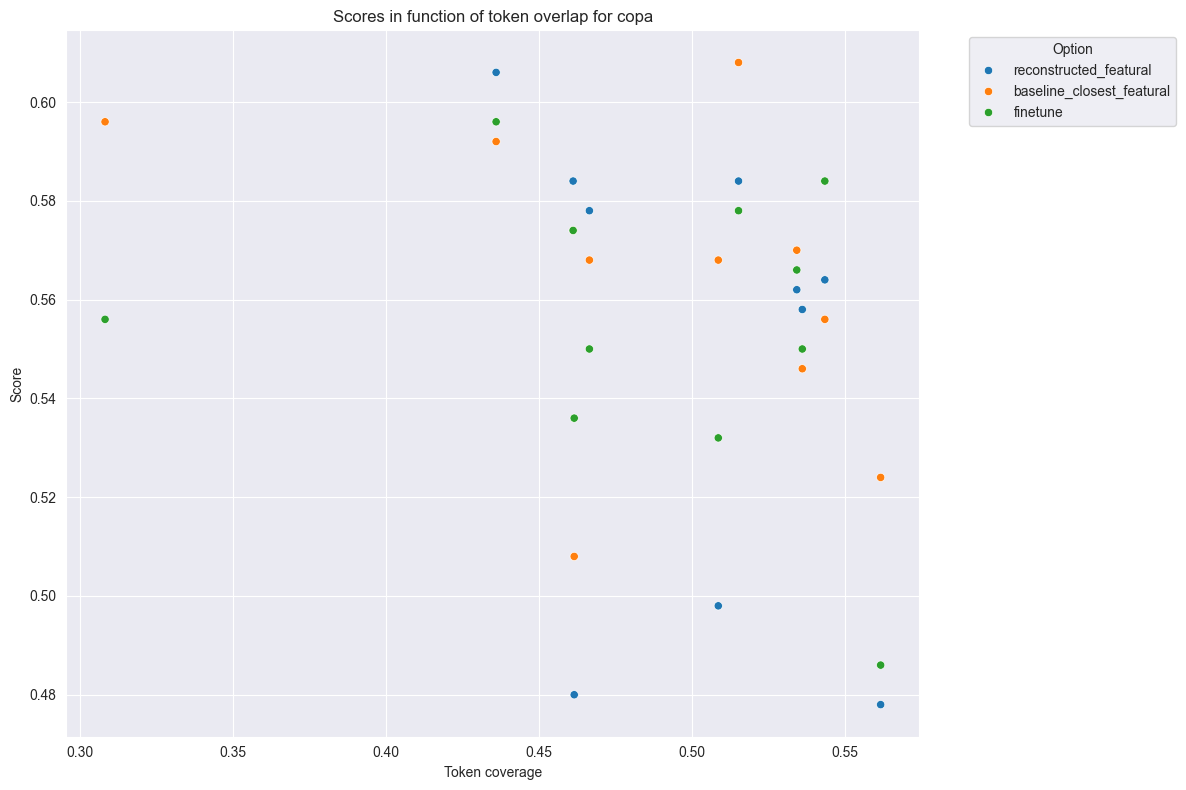

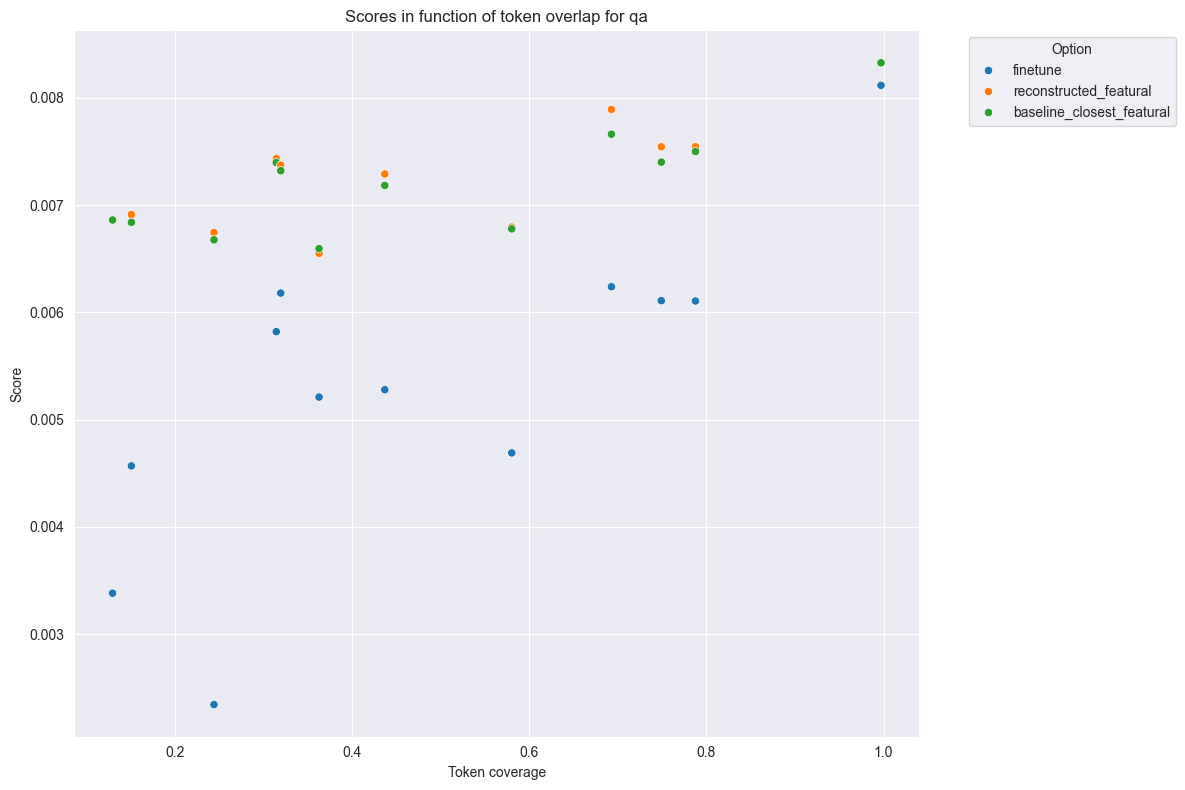

In [9]:
# we plot the scores in function of token overlap
tasks = df_subset["task"].unique()
for task in tasks:
    task_df = df_subset[df_subset["task"] == task]
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=task_df, x="token_coverage", y="score", hue="option")
    plt.title(f"Scores in function of token overlap for {task}")
    plt.xlabel("Token coverage")
    plt.ylabel("Score")
    plt.legend(title="Option", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

In [7]:
# we check the lowest baseline_en scores, print their languages and their token overlap
lowest_baseline_en = []
for task_name in scores:
    for lang_name in scores[task_name]:
        if "baseline_en" in scores[task_name][lang_name]:
            baseline_en_score = scores[task_name][lang_name]["baseline_en"]
            if task_name == "qa":
                baseline_en_score /= 100  # adjust for qa
            lowest_baseline_en.append((task_name, lang_name, baseline_en_score))
lowest_baseline_en.sort(key=lambda x: x[2])
for task_name, lang_name, score in lowest_baseline_en[:10]:  # print the 10 lowest scores
    token_coverage = token_overlap[task_name][lang_name]["token_coverage"]
    type_overlap = token_overlap[task_name][lang_name]["type_overlap"]
    print(
        f"Task: {task_name}, Language: {lang_name}, Baseline EN Score: {score}, Token Coverage: {token_coverage}, Type Overlap: {type_overlap}"
    )

Task: ner, Language: bo, Baseline EN Score: 0.0, Token Coverage: 0.8702397743300423, Type Overlap: 0.8888888888888888
Task: ner, Language: dv, Baseline EN Score: 0.0, Token Coverage: 0.9941972920696325, Type Overlap: 0.9142857142857143
Task: qa, Language: ar, Baseline EN Score: 0.006463741447356786, Token Coverage: 0.24416004653783926, Type Overlap: 0.1368202286110149
Task: qa, Language: zh, Baseline EN Score: 0.006556876083766825, Token Coverage: 0.3627623185726172, Type Overlap: 0.22265246853823814
Task: qa, Language: tr, Baseline EN Score: 0.006730734994589465, Token Coverage: 0.5802767485458056, Type Overlap: 0.5378106111484218
Task: qa, Language: hi, Baseline EN Score: 0.006752093847257739, Token Coverage: 0.12968266187665725, Type Overlap: 0.18704710144927536
Task: qa, Language: th, Baseline EN Score: 0.006898950862396228, Token Coverage: 0.15087134981274508, Type Overlap: 0.2709302325581395
Task: qa, Language: el, Baseline EN Score: 0.007138273122905983, Token Coverage: 0.436979

# Statistical analysis

In [ ]:
# we start by preparing a dataframe: language, scores (& baselines), true/false labels for xlm inclusion and for adapter availability
scores_inclusion = ["reconstructed_featural", "finetune", "baseline_en", "baseline_closest_featural", "no_train_gain"]
data = []
for task in tasks:
    for lang_name in scores[task]:
        if all(col in scores[task][lang_name] for col in scores_inclusion):
            data.append([task, lang_name] + [scores[task][lang_name][col] for col in scores_inclusion])
df = pd.DataFrame(data, columns=["task", "lang_name"] + scores_inclusion)
# we add a column for xlm inclusion and adaper availability
df["xlm_inclusion"] = df["lang_name"].apply(lambda x: 1 if x in xlm_included_langs else 0)
df["adapter_availability"] = df["lang_name"].apply(lambda x: 1 if x in existing_adapters else 0)
df["overall_average"] = df[scores_inclusion].mean(axis=1)
df["overall_average_exclude"] = df[scores_inclusion].drop(columns=["reconstructed_featural"]).mean(axis=1)
df["overall_improvement"] = df["reconstructed_featural"] - df["overall_average_exclude"]
df["madx_improvement"] = df["reconstructed_featural"] - df["baseline_closest_featural"]
df["train_gain_improvement"] = df["reconstructed_featural"] - df["no_train_gain"]
df["finetune_improvement"] = df["reconstructed_featural"] - df["finetune"]